In [286]:
#Code Prototype for 1D use on EXCLAIM Project with one sensor, code by Joaquin Matticoli

In [287]:
import numpy as np
import filterpy
from filterpy.kalman import KalmanFilter as kf
from filterpy.kalman import predict
from filterpy.kalman import update
from numpy.random import randn
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
import filterpy.stats as stats
import math
from math import sqrt

In [288]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

np.random.seed(24)

def print_gh(predict, update, z1, K):
    predict_template = '{: 7.3f} {: 8.3f}'
    update_template = '{:.3f}\t{: 7.3f} {: 7.3f}     {:.3f}'

    print(predict_template.format(predict[0], predict[1]),end='\t')
    print(update_template.format(z1, update[0], update[1], K))

In [289]:
class PayloadSimulation(object):
    def __init__(self, x0=0, angular_velocity2=1,
                 measurement1_var=0.0, measurement2_var = 0.0,
                 process_var=0.0):
        """ x0 : initial orientation
            angular_velocity: (+=counterclockwise, -=clockwise)
            measurement_var: variances in measurement deg^2
            process_var: variance in process (deg/s)^2
        """
        self.x = x0
        self.angular_velocity = angular_velocity2
        self.meas1_std = sqrt(measurement1_var)
        self.meas2_std = sqrt(measurement2_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new orientation of the payload in dt seconds."""
        dx = self.angular_velocity + abs(randn()*self.process_std)
        self.x += dx * dt

    def sense_position(self):
        """ Returns measurement of new orientation in degrees."""
        measurement = self.x + abs(randn()*self.meas1_std)
        return measurement
    
    def sense_velocity(self):
        """ Returns measurement of new angular velocity in deg/sec."""
        measurement2 = self.angular_velocity + abs(randn()*self.meas2_std)
        return measurement2

    def move_and_sense(self):
        """ Move payload, and return measurement of new orientation in degrees"""
        self.move()
        return self.sense_position()

In [290]:
printcase = 0 # If set to 1 it will print out the results
plotcase = 1 # If set to 1 it will plot results

#-----------USER INPUT STARTS------------------------------

number_of_variables = 2 #number of variables being measured
number_of_sensors = 1 #number of sensors used
process_var = 25. # variance in the payload's movement, idk what number is good for this??
sensor1_var = 2. # variance in the sensor
#sensor2_var = 0.5 # variance in second sensor
x = gaussian(0., 100.)  # payload's initial orientation in deg
angular_velocity = 0.5 # angular velocity in deg/s
dt = 2. # time step in seconds
n_iter = 75 # Number of measurements that the sensor will take

#-----------USER INPUT ENDS--------------------------------

process_model = gaussian(angular_velocity*dt, process_var) # displacement to add to x

    #NOTE: this code will assume that orientation is always increasing/decreasing and not sinusodial because a more complext Kalman filter is needed for those cases
    
# simulate payload and get measurements
payload = PayloadSimulation(
    x0=x.mean, 
    angular_velocity2=process_model.mean, 
    measurement1_var=sensor1_var, 
    process_var=process_model.var)

# creates list of measurements, NOTE: modify this section if measurements are provided
zs, zs2, ztrue = [], [], []
for _ in range(n_iter):
    zs.append(payload.move_and_sense())
    #zs2.append(payload.sense_velocity())
    ztrue.append(payload.x)
finalposition = payload.x

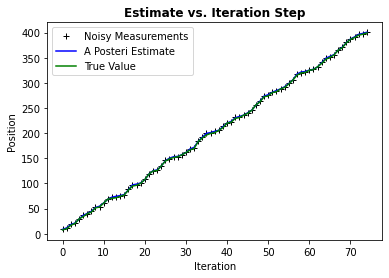

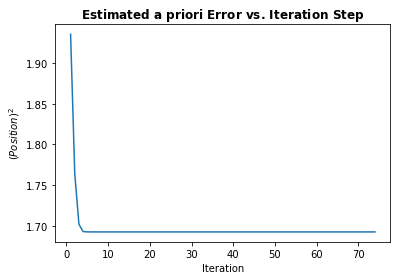

In [291]:
def plotstuff():
    plt.figure()
    plt.plot(zs,'k+',label='Noisy Measurements')
#     plt.plot(x1,'r*',label='A Priori Estimate')
    plt.plot(xhat,'b-',label='A Posteri Estimate')
    plt.plot(ztrue,color='g',label='True Value')
    #plt.plot(xhat,'r*',label='prediction')
    plt.legend()
    plt.title('Estimate vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('Position')
    
    plt.figure()
    valid_iter = range(1,n_iter) # Pminus not valid at step 0
    plt.plot(valid_iter,Pminus[valid_iter],label='A Posteri Error Estimate')
    plt.title('Estimated $\it{\mathbf{a \ priori}}$ Error vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('$(Position)^2$')
    #plt.setp(plt.gca(),'ylim',[0,.01])
    plt.show()

# x1 = np.zeros(n_iter)
#x2 = np.zeros(n_iter)
Pminus = np.zeros(n_iter)
xhat = np.zeros(n_iter)
counter = 0
if printcase == 1:
    print('PREDICT\t\t\t\tUPDATE')
    print('     x      var\t\t  z1\t    x      var         K')

# perform Kalman filter on measurement(s) z
f = kf(dim_x=number_of_variables, dim_z=number_of_sensors)
f.F = np.array([[1., dt], [0., 1.]]) #correct for calculating position from position and velocity
f.H = np.array([[1., 0.]]) #this is for first sensor measuring position
f.x = np.array([[x.mean], [angular_velocity*dt+randn()]])
#f.Q *= np.array([[(dt**3)/3, (dt**2)/2],
#                 [(dt**2)/2,  dt      ]]) * 0.02 #arbitrary
f.P = np.diag([x.var,process_var]) #Variance
f.R = sensor1_var  #Noise in sensors

for i in range(n_iter):    
    f.predict()
    prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
    f.update(zs[i])
    x = gaussian(f.x[0,0], f.P[0,0])
    if printcase == 1:
        print_gh(prior, x, zs[i], f.K[0,0])
    if plotcase == 1:
#         x1[i] = prior.mean
        xhat[i] = x.mean
        Pminus[i] = x.var

if printcase == 1:
    print()
    print('final estimate:           {:10.3f}'.format(x.mean))
    print('actual final orientation: {:10.3f}'.format(payload.x))
if plotcase == 1:
    plotstuff()